### This notebook
builds a graph-based embedding for a small number of random handwritten digits with multidimensional scaling.

Optional: run this before import to recompile c++ ops
```
!rm -r ../lib/cpp/temp/
!rm -r ../lib/cpp/build/
!rm -r ../lib/cpp/_bindings.so
!rm -r ../lib/cpp/bindings.py
!rm -r ../lib/cpp/lib_wrap.c
```


##### Get the dataset:

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "..")
import lib
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_iris, load_wine, load_digits
# 8x8 digit image loaded as a list of 64 elements
from IPython.display import clear_output

from tqdm import tqdm

torch.manual_seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
X, y = load_wine(return_X_y=True)  # load_iris
X = X / np.square(X).sum(-1, keepdims=True) ** 0.5

In [6]:
X.shape

(1797, 64)

In [8]:
batch_size = 64

In [13]:
distances = np.square(X[None, :, :] - X[:, None, :]).sum(-1)

In [23]:
distances_pca

array([[0.        , 0.87899041, 0.7126371 , ..., 0.63756803, 0.38113075,
        0.53788323],
       [0.87899041, 0.        , 0.18022665, ..., 0.26903744, 0.60423303,
        0.45831704],
       [0.7126371 , 0.18022665, 0.        , ..., 0.12098865, 0.43986148,
        0.29854224],
       ...,
       [0.63756803, 0.26903744, 0.12098865, ..., 0.        , 0.42345901,
        0.25435282],
       [0.38113075, 0.60423303, 0.43986148, ..., 0.42345901, 0.        ,
        0.32482266],
       [0.53788323, 0.45831704, 0.29854224, ..., 0.25435282, 0.32482266,
        0.        ]])

In [14]:
distances.shape

(1797, 1797)

##### Build initial graph

We initialize prodige with a full graph initialized with distances between nodes

In [10]:
from lib.task.compression import make_graph_from_vectors
emb = make_graph_from_vectors(
    X, knn_edges=100, max_length=10, n_jobs=-1, soft=True, directed=False, verbose=True
)

opt = torch.optim.SparseAdam(emb.parameters(), lr=0.01)

distances = np.square(X[None, :, :] - X[:, None, :]).sum(-1)
loss_history, reg_history = [], []
batch_size = 178

# uncomment to deliberately mess with weights for testing purposes
# emb.edge_weight_logits.reset_parameters()
# emb.edge_adjacency_logits.reset_parameters()

Searching for nearest neighbors
Adding knn edges
Deduplicating edges
Total edges: 10707, mean edges per vertex: 60.151685393258425, mean distance: 0.04357031732797623


..\lib\task\compression\__init__.py:49: UserWarning: faiss not found, using slow knn instead
  warn("faiss not found, using slow knn instead")


##### Training loop

Here we minimize the MDS loss function
$$L = 1/N \sum_{i, j} (d_{orig}(x_i, x_j) - d_G(v_i, v_j))^2$$

* $d_{orig}(x_i, x_j)$ is the original distance between two vectors in $X$
* $d_G(v_i, v_j)$ is the learned graph distance between corresponding vertices in graph $G$

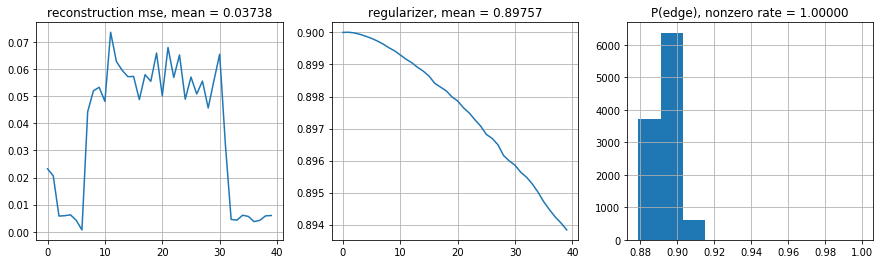










  0%|▏                                                                            | 30/9990 [10:34<55:19:14, 20.00s/it]

KeyboardInterrupt: 

In [21]:
for batch_i in tqdm(range(len(loss_history), 10000)):
    ii = torch.randint(0, len(X), [batch_size])
    jj = torch.randint(0, len(X), [batch_size])

    pred = emb(ii, jj)
    distances_ref = torch.as_tensor(distances[ii, jj], dtype=torch.float32)
    
    reconstruction_mse = F.mse_loss(pred['target_distances'], distances_ref)
    
    if len(loss_history) < 5000:
        regularizer = emb.compute_l0_prior_penalty(batch_size=4096)
    else:
        regularizer = emb.compute_hierarchical_prior_penalty(nonzero_rate=0.05, batch_size=4096)

    lambd = min(1, len(loss_history) / 5000.) * 10.0
    loss = reconstruction_mse - pred['logp_target_paths'].mean() + lambd * regularizer
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(reconstruction_mse.item())
    reg_history.append(regularizer.item())
    

    clear_output(True)
    plt.figure(figsize=[15, 4])
    plt.subplot(1, 3, 1);
    plt.title('reconstruction mse, mean = %0.5f' % np.mean(loss_history[-100:])); plt.grid()
    plt.plot(loss_history)

    plt.subplot(1, 3, 2);
    plt.title('regularizer, mean = %0.5f' % np.mean(reg_history[-100:])); plt.grid()
    plt.plot(reg_history)

    plt.subplot(1, 3, 3);
    probs = torch.sigmoid(emb.edge_adjacency_logits).data.numpy().flatten()
    nnz_rate = np.mean(probs > 0.5)
    plt.title('P(edge), nonzero rate = %.5f' % nnz_rate); plt.grid();
    plt.hist(probs)
    plt.show()

In [14]:
print(emb)

GraphEmbedding(178 vertices, 10708 edges total, 10708 edges kept, 0.0 sparsity rate, default distance = 0.0)


In [ ]:
distances_ours = emb.compute_pairwise_distances()

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4).fit(X)
X_pca = pca.inverse_transform(pca.transform(X))
distances_pca = np.concatenate([
    np.square(X_pca[None, :, :] - X_pca[batch_start: batch_start + batch_size, None, :]).sum(-1) ** 0.5
    for batch_start in range(0, len(X_pca), batch_size)
])

In [15]:
distances_pca.shape

(1797, 1797)

In [25]:
distances_pca

array([[0.        , 0.87899038, 0.71263714, ..., 0.63756805, 0.38113072,
        0.53788326],
       [0.87899038, 0.        , 0.18022662, ..., 0.26903739, 0.60423303,
        0.45831701],
       [0.71263714, 0.18022662, 0.        , ..., 0.12098868, 0.4398615 ,
        0.29854225],
       ...,
       [0.63756805, 0.26903739, 0.12098868, ..., 0.        , 0.42345901,
        0.25435281],
       [0.38113072, 0.60423303, 0.4398615 , ..., 0.42345901, 0.        ,
        0.32482266],
       [0.53788326, 0.45831701, 0.29854225, ..., 0.25435281, 0.32482266,
        0.        ]])

In [21]:
distances

array([[0.        , 0.96179531, 0.76631603, ..., 0.57756665, 0.34838406,
        0.5113807 ],
       [0.96179531, 0.        , 0.40281765, ..., 0.31255909, 0.55331713,
        0.54922793],
       [0.76631603, 0.40281765, 0.        , ..., 0.30544758, 0.59232316,
        0.41156081],
       ...,
       [0.57756665, 0.31255909, 0.30544758, ..., 0.        , 0.40911985,
        0.16608492],
       [0.34838406, 0.55331713, 0.59232316, ..., 0.40911985, 0.        ,
        0.33208289],
       [0.5113807 , 0.54922793, 0.41156081, ..., 0.16608492, 0.33208289,
        0.        ]])

In [10]:
from sklearn.manifold import MDS
mds = MDS(n_components=4, random_state=42, n_jobs=-1, dissimilarity='euclidean')
X_mds = mds.fit_transform(X)
distances_mds = np.square(X_mds[None, :, :] - X_mds[:, None, :]).sum(-1) ** 0.5

In [12]:
distances_mds.shape

(1797, 1797)

In [16]:
print("PCA:\t %.5f" % np.mean(np.square(distances - distances_pca)))
print("MDS:\t %.5f" % np.mean(np.square(distances - distances_mds)))
# print("PRODIGE: %.5f" % np.mean(np.square(distances - distances_ours)))

PCA:	 0.02119
MDS:	 0.02555


In [ ]:
from bokeh import io
from bokeh.plotting import figure, output_file, save
output_file('mnist_graph.html')
emb.default_distance.data[...] = 100
p = lib.visualize_embeddings(emb, vertex_labels=y, edge_probability_threshold=0.5, deterministic=True,
                         vertex_alpha=0.8, cmap=lambda x: plt.get_cmap('rainbow')(x))
save(p, 'mnist_graph.html')

In [ ]:
from IPython.display import HTML
HTML(filename="graph.html")
# re-run several times to get different tsne optima

```

```

```

```

```

```

```

```

```

```
